# Debiasing Notebook

This notebook takes in binned and cleaned Galaxy Zoo data and produces a debiased output catalogue. This notebook is based on the procedure outlined in [Hart et al. 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.461.3663H/abstract), and original debiasing efforts hosted on the GAMA branch of [this GitHub repo](https://github.com/RossHart/Debiasing/tree/GAMA).

In [1]:
# imports
import os
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Table, join
from scipy.ndimage import gaussian_filter

# one-liners
def npseq(a, b, by): return np.arange(a, b + by/2, by)
def npmad(x): return 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))
def ddir(x): return [y for y in dir(x) if not y.startswith('__')]
def minmax(x): return [np.nanmin(x), np.nanmax(x)]
def extendrange(x,f=0.05):u,v=minmax(x);d=(v-u)*(1+f);return v-d,u+d
def findin(x, y): return [l for l in list(x) if y in str(l)]

# startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
nbtf = '%Y-%m-%d %H:%M:%S %Z'
nbt0 = time.time()
nbt0str = time.strftime(nbtf, time.localtime(nbt0))
print(f'Notebook start time: \n   {nbt0str}')
#--------------------------------68-------------------------------->

Notebook start time: 
   2020-10-06 08:42:20 CDT


## Configuration

In [72]:
# data locations
inputVoteFracCat = '../gkgz-cleaned.fits.gz'
inputExtraValCat = '../gkgz-extra.fits.gz'
outputDir = os.path.abspath('.')
outputCat = f'{outputDir}/gkgz-debiased.fits.gz'

# column names
sizeCol = 'GALRE_r_kpc'
magCol = 'absmag_r'
zCol = 'Z_TONRY'
IDCol = ['gama_cataid', 'CATAID']
inputTotalSuffix = '_clean_total'
inputFracSuffix = '_clean_frac'
outputFracSuffix = '_deb_frac'

# limits
sizeLim = (0.4, 25)
magLim = (-15, -23)
zBounds = npseq(0.025, 0.155, 0.01)

# debiasing parameters
priorP = 0.5
priorN = 5

# plotting setup
dpi = 300
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols[0],cols[1] = cols[1],cols[0]

## Data Input and Preview

In [73]:
# read in data
vfCat = Table.read(inputVoteFracCat)
evCat = Table.read(inputExtraValCat)
if IDCol[0] != IDCol[1]:
    evCat.rename_column(IDCol[1], IDCol[0])
if any(vfCat[IDCol[0]] != evCat[IDCol[0]]):
    raise ValueError("input catalogues must be row matched by ID!")

In [74]:
# join vote fraction cat to extra values cat
dat = join(vfCat, evCat, keys=IDCol[0], metadata_conflicts='silent')

In [75]:
def kde2d(x, y, xlim = None, ylim = None, nx = 25, ny = 25,
          sigma = None, xlog = False, ylog = False,
          levels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):
    """2D kernel density estimator."""
    old = np.seterr(invalid='ignore')
    xlim = [np.nanmin(x), np.nanmax(x)] if xlim is None else xlim
    ylim = [np.nanmin(y), np.nanmax(y)] if ylim is None else ylim
    if xlog:
        x = np.log10(x)
        xlim = np.log10(xlim)
    if ylog:
        y = np.log10(y)
        ylim = np.log10(ylim)
    bins = [int(nx), int(ny)]
    Z, X, Y = np.histogram2d(x, y, bins, [xlim, ylim])
    if xlog:
        X = 10**X
    if ylog:
        Y = 10**Y
    X = (X[1:] + X[:-1]) / 2
    Y = (Y[1:] + Y[:-1]) / 2
    sigma=[np.sqrt(nx)/5,np.sqrt(ny)/5] if sigma is None else sigma
    Z = gaussian_filter(Z, sigma)
    L = []
    if levels:
        V = sorted(np.ravel(Z))
        C = np.cumsum(V)
        for lvl in levels:
            L.append(V[np.abs(C - (C[-1]*lvl)).argmin()])
    np.seterr(**old)
    return X, Y, Z.T, [xlim, ylim], L

In [77]:
magLim

(-15, -23)

In [78]:
extendrange(magLim, f=0.2)

(-24.6, -13.4)

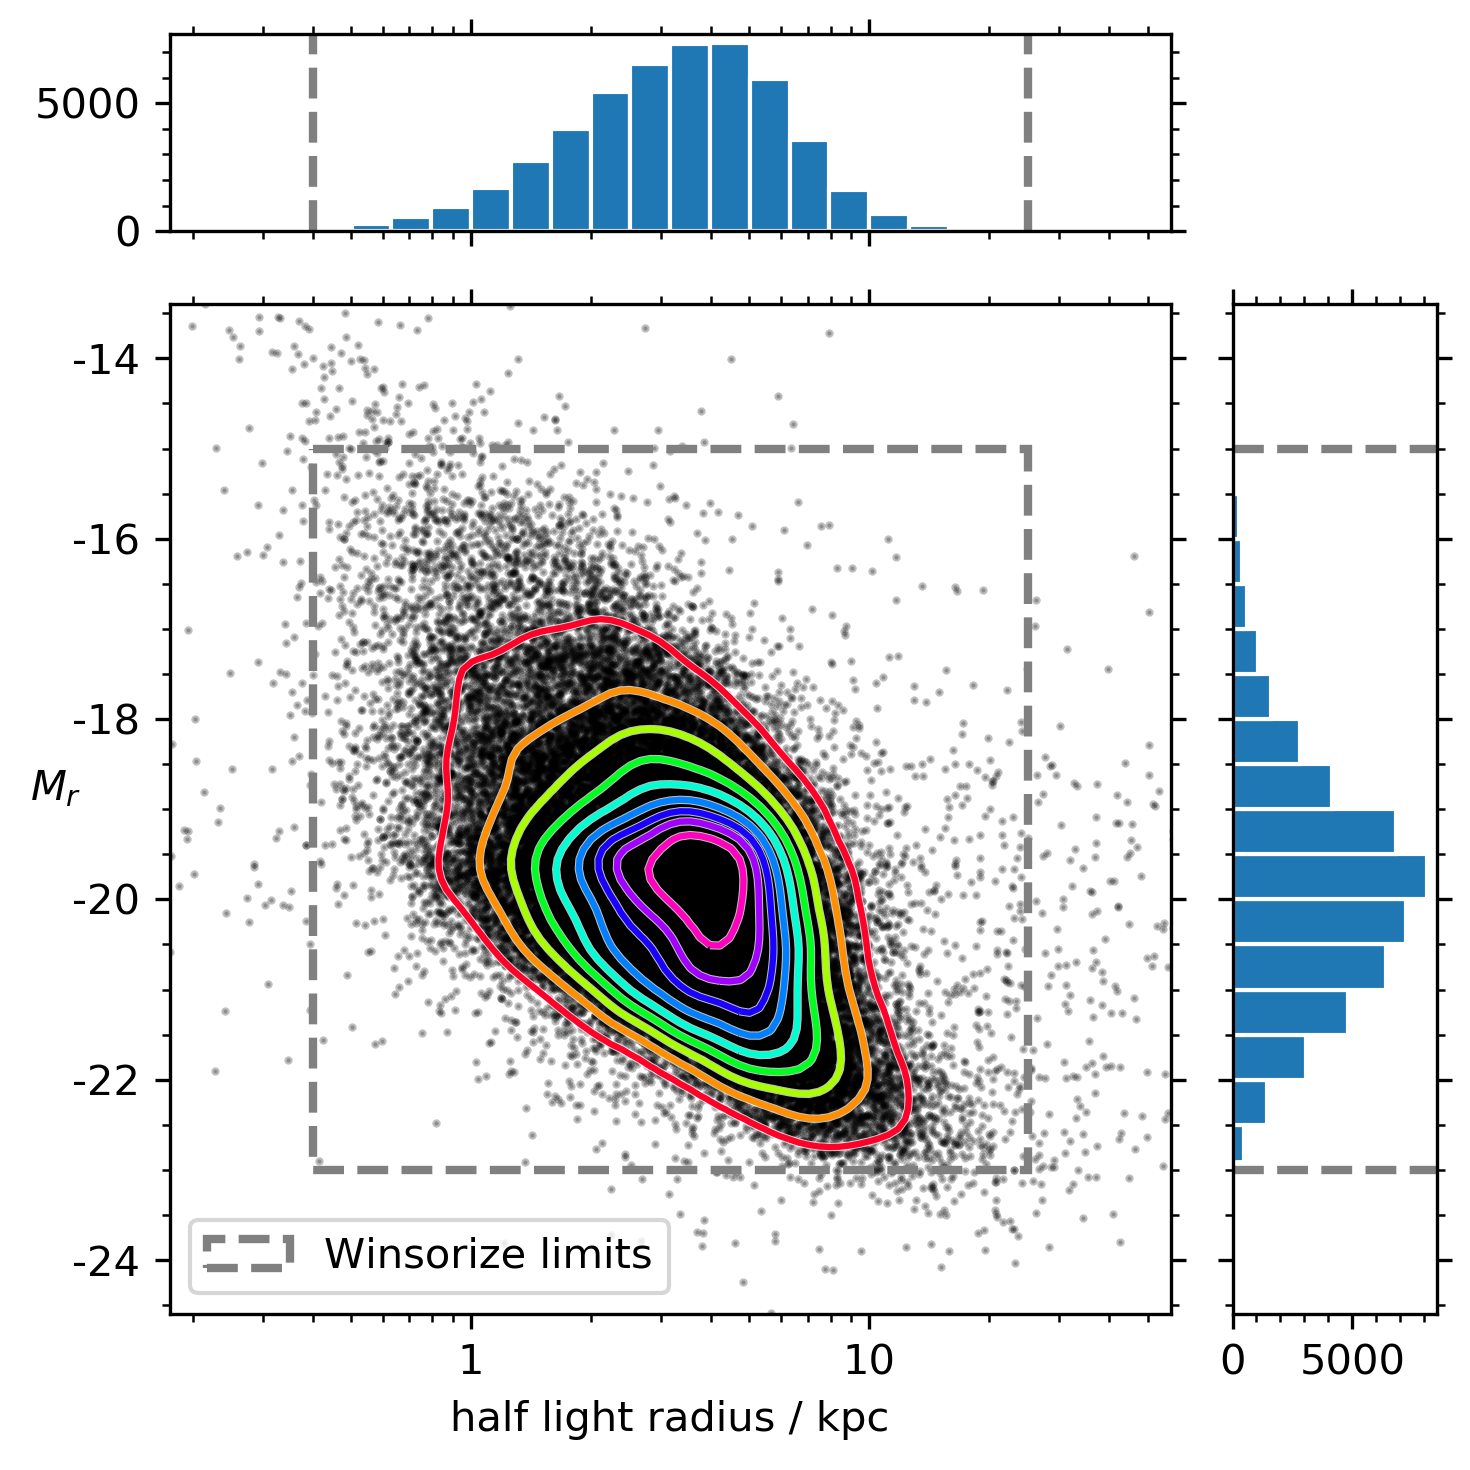

In [76]:
# data preview
size = dat[sizeCol]
mag = dat[magCol]
winsorColor = 'grey'
outerSizeLim = 10**np.array(extendrange(np.log10(sizeLim), f=0.2))
outerMagLim = extendrange(magLim, f=0.2)
X, Y, Z, extent, L = kde2d(size, mag, outerSizeLim, outerMagLim,
                           xlog=True, nx=101, ny=101)

fig = plt.figure(figsize=(5,5), dpi=dpi)
gs = matplotlib.gridspec.GridSpec(5, 5, figure=fig)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _: '{:g}'.format(y))

ax = fig.add_subplot(gs[-4:,:4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.scatter(size, mag, c='k', s=1, alpha=0.25, label='')
ax.contour(X, Y, Z, L, colors='white', alpha=0.75, linewidths=2)
ax.contour(X, Y, Z, L, cmap='gist_rainbow', alpha=1)
rect = matplotlib.patches.Rectangle((sizeLim[0], magLim[0]),
                                    np.diff(sizeLim),
                                    np.diff(magLim),
                                    linewidth=2,
                                    edgecolor=winsorColor,
                                    facecolor='none',
                                    linestyle='--', 
                                    label='Winsorize limits',)
ax.add_patch(rect)
ax.set_xscale('log')
ax.set_xlabel('half light radius / kpc')
ax.set_ylabel('$M_r$', rotation=0)
ax.set_xlim(outerSizeLim)
ax.set_ylim(outerMagLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.legend(loc='lower left')

ax = fig.add_subplot(gs[0,:4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.set_xlim(outerSizeLim)
ax.hist(size, bins=np.logspace(-3, 4, 71), log=False, label='',
        edgecolor='white', color=cols[1])
plt.axvline(sizeLim[0], c='white', ls='-', lw=5)
plt.axvline(sizeLim[1], c='white', ls='-', lw=5)
plt.axvline(sizeLim[0], c=winsorColor, ls='--', lw=2)
plt.axvline(sizeLim[1], c=winsorColor, ls='--', lw=2)
ax.set_xscale('log')
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xticklabels([])

ax = fig.add_subplot(gs[-4:,4])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
ax.set_ylim(outerMagLim)
ax.hist(mag, bins=np.arange(-30,-9,0.5), log=False, label='',
        edgecolor='white', color=cols[1], orientation='horizontal')
plt.axhline(magLim[0], c='white', ls='-', lw=5)
plt.axhline(magLim[1], c='white', ls='-', lw=5)
plt.axhline(magLim[0], c=winsorColor, ls='--', lw=2)
plt.axhline(magLim[1], c=winsorColor, ls='--', lw=2)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_yticklabels([])

plt.tight_layout()
plt.show()
plt.close()

In [269]:
extent

[array([-0.57752801,  1.57752801]), (-23.8, -14.2)]